## Importing Libraries and Reading in CSV Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
%matplotlib inline

In [3]:
#read in data (90,348 rows not inclusive of header)
df = pd.read_csv("data/Aviation_Data.csv")

#print(df.info(), '\n \n')

C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Preliminary Formatting Change and Filtering

In [5]:
# Replaces "." with "_" in column names for ease of copy, paste
df.columns = df.columns.str.replace('.', "_")

# Unifying name for several Manufacturers with mulitple names.
df_dict_name = {'Aviat' : 'Aviat Aircraft Inc', 'Cirrus' : 'Cirrus Design Corp' , 'Cirrus Design Corp.' : 'Cirrus Design Corp', 
                'Gulfstream' : 'Gulfstream Aerospace', 'Learjet' : 'Learjet Inc', 'Raytheon' : 'Raytheon Aircraft Company',
               'De Havilland' : 'Dehavilland'}  
df['Make'] = df['Make'].replace(df_dict_name)

# Filtering dataframe to only show entries in Aircraft_Category that are Airplane. Reducing to 27,617 rows.
df = df.loc[df['Aircraft_Category'] == 'Airplane']

# The company will utilize professionally built planes. To best understand risk associated wiht professionally
# built planes, amateur-built will be removed from the dataset. Reducing to 24,417 rows.
df = df.loc[df['Amateur_Built'] == 'No']

# Extracting year from Event Date to assess how data changes by year
df['Year'] = [str(year).split('-')[0] for year in df['Event_Date']]
# Filtering dataframe to only show entries that have a Year 2000 as there were stricter air regulations enforced after 9/11
# and it makes sense to only show data around 20 years back from our problem. Reducing to 21,150 rows.
df = df.loc[df['Year'].astype(int) > 2000]

#Filtering out entries from Purpose_of_flight that arent one of 7 categories(Personal, Business, Executive/Corporate,
#Public Aircraft - Federal, Public Aircraft - State, Public Aircraft - Local or Public Aircraft)
#This is because we are looking to find an aircraft specifically for commercial and private activities. Reducing to 12,380 rows.
df = df.loc[df['Purpose_of_flight'].isin(['Personal','Business', 'Executive/corporate', 'Public Aircraft - Federal', 
                                          'Public Aircraft - State', 'Public Aircraft - Local', 'Public Aircraft'])]

# Same Makes showing up as different because of capitalization. Changing all Makes and Model to Title case
df['Make'] = [make.title() for make in df['Make']]

# Dropping of investigations where US Location is Unknown
df = df.drop(df[(df['Country'] == 'United States') & (df['Location'] == 'Unknown,')].index)
df = df.drop(df[(df['Country'] == 'United States') & (df['Location'] == ',')].index)

# Cleaning of US Locations to ensure all include abbreviations, where o, = Gulf of Mex, g, = Tamuning, GUAM (GU), 
#e, = Charlotte Amalie, VI, PO = Pacific Ocean, VI = Virgin Islands, d, = Christiansted, VI,
#x, = St. Croix, VI, a, = Santa Rita, NM, O, = Gulf of Mexico, GM
df_dict_abbrev = {'Gulf of Mexico,' : 'Gulf of Mexico, GM', 'Tamuning,' : 'Tamuning, GU' , 
                  'Charlotte Amalie,' : 'Charlotte Amalie, VI', 'Christiansted,' : 'Christiansted, VI', 
                  'St. Croix,' : 'St. Croix, VI', 'Santa Rita,' : 'Santa Rita, NM', 'GULF OF MEXICO,' : 'Gulf of Mexico, GM'} 
df['Location'] = df['Location'].replace(df_dict_abbrev)

# Grabbing state abbreviations from Locations column
df['State'] = df.apply(lambda row: row['Location'][-2:] if row['Country'] == 'United States' else None, axis = 1)

# Mapping states to four regions: Northwest, Northeast, Southwest, Southeast
state_map = {'NW' : ['AK', 'ID', 'MT', 'ND', 'NE', 'OR', 'SD', 'WA', 'WY'], 'NE' : ['CT', 'DE', 'IA', 'IL', 'IN', 'KY', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NH', 'NJ', 'NY', 'OH', 'PA', 'RI', 'VA', 'VT', 'WI', 'WV'], 
                 'SW' : ['AZ', 'CA', 'CO', 'HI', 'KS', 'NM', 'NV', 'OK', 'PO', 'TX', 'UT'], 'SE' : ['AL', 'AR', 'FL', 'GA', 'GM', 'GU', 'LA', 'MS', 'NC', 'AO', 'PR', 'SC', 'TN', 'VI']}
df['Region'] = df['State'].map({v: k for k, values in state_map.items() for v in values})

# For Weather Condition, unknown is represented by "Unk" and "UNK". Converting them both to "Unknown".
df = df.replace(('Unk', 'UNK'), 'Unknown')

# Replacing NaN with 0 for all injury data
df["Total_Fatal_Injuries"].fillna(0, inplace=True)
df["Total_Serious_Injuries"].fillna(0, inplace=True)
df["Total_Minor_Injuries"].fillna(0, inplace=True)
df["Total_Uninjured"].fillna(0, inplace=True)


#df.info()

## Exploratory Data Analysis

##  Quantifying impact to human safety and airplane damage

In [39]:
#Calculating the total number of passengers (assuming) = killed + injured + not-injured and per cent of passengers
#killed or injured. Total Passengers = 0 for 25 entries.

df['Total_Passengers'] = df['Total_Fatal_Injuries'] + df['Total_Serious_Injuries'] + df['Total_Minor_Injuries'] + df['Total_Uninjured']

df['Fatality_pct'] = df['Total_Fatal_Injuries'] / df['Total_Passengers'] * 100

df['Injured_pct'] = (df['Total_Serious_Injuries'] + df['Total_Minor_Injuries']) / df['Total_Passengers'] * 100

In [40]:
#Assuming Aircraft_damage = NaN or Unknown = No damage. Created new feature 'Airplane_Damage' to capture these
#definitions.

ad_dict = {'Destroyed' : 'Destroyed', 'Substantial' : 'Substantial', 'Minor' : 'Minor', 'Unknown' : 'No damage', np.nan : 'No damage'}
df['Airplane_Damage'] = df['Aircraft_damage'].map(ad_dict)

In [41]:
# Making Airplane_Damage quantitative
ad_dict_quant = {'Destroyed' : 3, 'Substantial' : 2, 'Minor' : 1, 'No damage' : 0}
df['Airplane_Damage_quant'] = df['Airplane_Damage'].map(ad_dict_quant)

In [42]:
# Seperating flights into Commercial vs Private dataframes
df_com = df.loc[df['Purpose_of_flight'].isin(['Personal', 'Public Aircraft - Federal', 
                                          'Public Aircraft - State', 'Public Aircraft - Local', 'Public Aircraft'])]
df_pri = df.loc[df['Purpose_of_flight'].isin(['Business', 'Executive/corporate'])]
# Filtering out Commercial so only the Makes that have the top 20 counts are kept
df_com = df_com.loc[df_com['Make'].isin(list(df_com['Make'].value_counts()[:20].index))]

# Filtering out Private so only the Makes that have the top 20 counts are kept
# Then further filtering out Makes that either have an injured percentile mean or a fatality percentile mean that is 0
df_pri = df_pri.loc[df_pri['Make'].isin(list(df_pri['Make'].sort_values(ascending = False).value_counts()[:20].index))]
make = [company for company in df_pri['Make'].value_counts().index if df_pri[df_pri["Make"] == company]['Injured_pct'].mean() > 0]
df_pri = df_pri[df_pri['Make'].isin(make)]
make = [company for company in df_pri['Make'].value_counts().index if df_pri[df_pri["Make"] == company]['Fatality_pct'].mean() > 0]
df_pri = df_pri[df_pri['Make'].isin(make)]

## Write to File

In [43]:
#df_pri.to_csv("data/Output_Data.csv")
#df_com.to_csv("data/Output_Data_commercial.csv")
#df_pri.to_csv("data/Output_Data_private.csv")

## Appendix

### Assessing changes

In [44]:
#Create a Value Count for each column
for i in range(len(df.columns)):
    print(df.iloc[:, i].value_counts(), '\n', '\n', '----------------------------------------\n')

20220323104818    2
20220818105763    2
20220608105217    2
20030625X00951    2
20220822105776    2
                 ..
20120623X90047    1
20091210X11649    1
20210907103802    1
20140108X83046    1
20140312X22036    1
Name: Event_Id, Length: 12367, dtype: int64 
 
 ----------------------------------------

Accident    12259
Incident      116
Name: Investigation_Type, dtype: int64 
 
 ----------------------------------------

WPR22LA201    2
ERA22LA103    2
CEN22LA149    2
ERA22LA364    2
WPR22FA309    2
             ..
WPR18LA179    1
CEN22LA177    1
CEN16LA090    1
WPR17IA173    1
WPR09LA268    1
Name: Accident_Number, Length: 12368, dtype: int64 
 
 ----------------------------------------

2011-07-23    10
2007-10-07    10
2022-07-15    10
2008-08-02    10
2008-06-29    10
              ..
2019-07-08     1
2020-03-27     1
2013-12-31     1
2015-06-07     1
2006-03-24     1
Name: Event_Date, Length: 5445, dtype: int64 
 
 ----------------------------------------

Anchorage, AK     

### Investigations Over Time

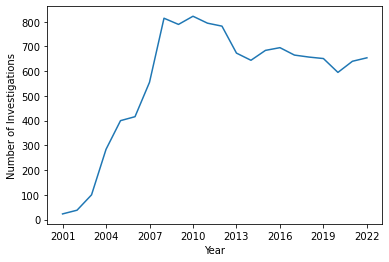

In [45]:
inv_years = df['Year']
inv_years_dist = inv_years.value_counts().sort_index()
inv_years_dist

fig, ax = plt.subplots()

ax.plot(inv_years_dist.index, inv_years_dist.values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel('Number of Investigations')
ax.set_xlabel("Year")
plt.show()

### Assessment of Investigation Type over Time

In [46]:
inv_years_acc = df.loc[df['Investigation_Type'] == 'Accident']['Year']
inv_years_dist_acc = inv_years_acc.value_counts().sort_index()

df_inv_type_acc = pd.DataFrame(inv_years_dist_acc).reset_index()
df_inv_type_acc.columns = ['Year', 'Accidents']

inv_years_inc = df.loc[df['Investigation_Type'] == 'Incident']['Year']
inv_years_dist_inc = inv_years_inc.value_counts().sort_index()

df_inv_type_inc = pd.DataFrame(inv_years_dist_inc).reset_index()
df_inv_type_inc.columns = ['Year', 'Incidents']

df_inv_type_merge = pd.merge(df_inv_type_acc, df_inv_type_inc, how = 'outer', on = 'Year')
df_inv_type_merge['Incidents'] = df_inv_type_merge['Incidents'].fillna(0)

df_inv_type_merge['Accidents_pct'] = df_inv_type_merge['Accidents'] / (df_inv_type_merge['Accidents'] + df_inv_type_merge['Incidents']) * 100
df_inv_type_merge['Incidents_pct'] = df_inv_type_merge['Incidents'] / (df_inv_type_merge['Accidents'] + df_inv_type_merge['Incidents']) * 100

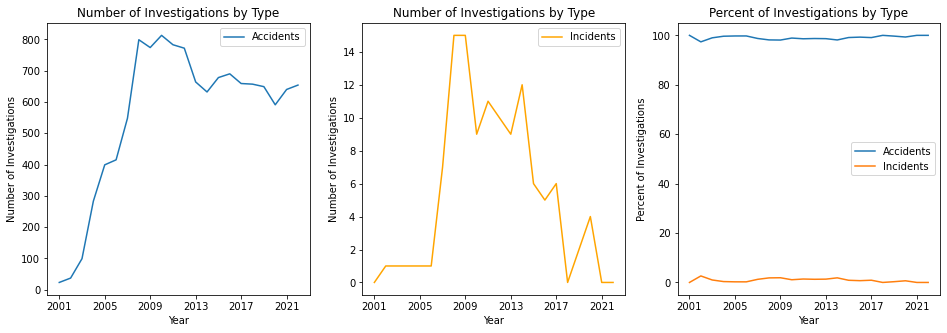

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (16, 5))

ax1.plot(df_inv_type_merge['Year'], df_inv_type_merge['Accidents'], label = 'Accidents')

ax2.plot(df_inv_type_merge['Year'], df_inv_type_merge['Incidents'], label = 'Incidents', color='orange')

ax3.plot(df_inv_type_merge['Year'], df_inv_type_merge['Accidents_pct'], label = 'Accidents')
ax3.plot(df_inv_type_merge['Year'], df_inv_type_merge['Incidents_pct'], label = 'Incidents')

ax1.legend()
ax2.legend()
ax3.legend()

ax1.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(4))

ax1.set_title('Number of Investigations by Type')
ax1.set_ylabel('Number of Investigations')
ax1.set_xlabel("Year")

ax2.set_title('Number of Investigations by Type')
ax2.set_ylabel('Number of Investigations')
ax2.set_xlabel("Year")

ax3.set_title('Percent of Investigations by Type')
ax3.set_ylabel('Percent of Investigations')
ax3.set_xlabel("Year")

plt.show()